In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Class for simple Linear classifier

In [3]:
# A very simple linear neural network with input dimension 2 
# and output dimension 2 (the discriminant function for each class)

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim=2, output_dim=2):
        super(LinearClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x

In [4]:
# a function that takes in a binary linear classifier's weights and biases
# and plots the decision boundary line in [-4,4] * [-4,4]

def plot_db(wb, modelType='[modelType]', lins='r'):

    w0, w1, b0, b1 = wb[0], wb[1], wb[2], wb[3]
    x0 = np.linspace(-4,4,100)
    x1 = (b1 - b0 - (w0[0] - w1[0]) * x0) / (w0[1] - w1[1])
    plt.plot(x0, x1, lins, label=f'{modelType}')

### Synthetic data generation and visualisation

10,000 samples - 95% from Gaussian centered at (-1, -1) with covariance I; the remaining 5% from Gaussian centered at (1, 1) with covariance I.

In [5]:
N = 10000
class_prob = [0.95, 0.05]
class_freq = [int(N * i) for i in class_prob]

covariance = np.identity(2) # change to np.identity(2) * 0.04 to get separable data
np.random.seed(2022) # fix seed for a reproducable training set
sampA = np.random.multivariate_normal([-1,-1], covariance, class_freq[0])
sampB = np.random.multivariate_normal([1,1], covariance, class_freq[1])
np.random.seed()

X_values = np.concatenate((sampA, sampB), axis=0) # N-by-2 data matrix
y_flat = np.array([0] * class_freq[0] + [1] * class_freq[1]) # row vector of labels

index_shuffle = np.arange(len(X_values))
np.random.shuffle(index_shuffle)

# shuffle the rows of data matrix and labels

X_values = X_values[index_shuffle]
y_flat = y_flat[index_shuffle]

# convert to Torch tensors

X_train = torch.tensor(X_values).type(torch.FloatTensor)
y_train = torch.from_numpy(y_flat).view(-1,1).type(torch.LongTensor)

### Training the standard classifier 

With single layer NN with Cross-Entropy Loss (for binary classification equivalent to a sigmoid classifier)

In [6]:
# Create a Linear neural network with randomly initialised weights and biases
# Each trained network begins with the same initialisation, as they all start
# as copies of this network

model_bin_orig = LinearClassifier()

In [7]:
# input: model
# output: weights and biases in an array
# optional: additive update to biases or multiplicative update to weight and biases

def getwb(model, add=[0,0], mult=[1,1]):
    return [model.linear.weight[0].detach().numpy()/mult[0], model.linear.weight[1].detach().numpy()/mult[1], (model.linear.bias[0].detach().numpy()+add[0])/mult[0], (model.linear.bias[1].detach().numpy()+add[1])/mult[1]]

In [8]:
# input: model, optimizer for parameters for that model, criterion (or loss)
# optional: additive update to outputs before passing through loss function
# and trains model and updates its parameters

def modelTrain(model, optimizer, criterion, adjust=0):
    for epoch in range(10000):
    
        # zero the gradients
        optimizer.zero_grad()

        # forward
        output = model(X_train)
        loss = criterion(output + adjust, y_train.view(-1))

        # backward
        loss.backward()

        # optimize
        optimizer.step()

In [9]:
# unweighted cross-entropy ERM
model_bin = deepcopy(model_bin_orig)
optimizer_bin = torch.optim.SGD(model_bin.parameters(), lr=0.1, weight_decay=0)
criterion_bin = torch.nn.CrossEntropyLoss()

In [10]:
modelTrain(model_bin, optimizer_bin, criterion_bin)

### Loss modified

Balance the loss

In [11]:
# class-weighted cross-entropy ERM
model_bin_bal = deepcopy(model_bin_orig)
optimizer_bin_bal = torch.optim.SGD(model_bin_bal.parameters(), lr=0.1, weight_decay=0)
criterion_bin_bal = torch.nn.CrossEntropyLoss(weight = torch.tensor(np.reciprocal(class_prob)).type(torch.FloatTensor))

In [12]:
modelTrain(model_bin_bal, optimizer_bin_bal, criterion_bin_bal)

In [13]:
beta = 0.999
cui_weights = [(1 - beta) / (1 - beta ** i) for i in class_freq] # inverse effective number for each class
cui_weights = [i / sum(cui_weights) for i in cui_weights] # normalise weights
cui_weights = torch.tensor(cui_weights).type(torch.FloatTensor)

In [14]:
# weighted cross-entropy with beta=0.999
model_bin_cui = deepcopy(model_bin_orig)
optimizer_bin_cui = torch.optim.SGD(model_bin_cui.parameters(), lr=0.1, weight_decay=0)
criterion_bin_cui = torch.nn.CrossEntropyLoss(weight = cui_weights)

In [15]:
modelTrain(model_bin_cui, optimizer_bin_cui, criterion_bin_cui)

### Cao's LDAM loss

In [16]:
# LDAM Loss taken from Cao et. al code and modified

class LDAMLoss(nn.Module):
    def __init__(self, class_prob, weight=None):
        super(LDAMLoss, self).__init__()
        delta = 1.0 / np.sqrt(np.sqrt(class_prob))
        delta = torch.FloatTensor(delta)
        self.delta = delta
        self.weight = weight

    def forward(self, outputs, target):
        # one-hot encodes the binary labels
        index = torch.zeros_like(outputs, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        index_float = index.type(torch.FloatTensor)

        # column vector of the margin adjustments
        batch_m = torch.matmul(self.delta[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))

        # computes logits modified by subtracting the margin for each example (determined by the true class) from the each output for it
        outputs_m = outputs - batch_m
    
        # for each example, replace the logit for the true class by the modified one, and keep the others the same
        output = torch.where(index, outputs_m, outputs)

        # computes the mean of cross-entropy losses for each example and its adjusted output
        return F.cross_entropy(output, target, weight=self.weight)

In [17]:
# Train with Cao's LDAM loss
model_bin_cao = deepcopy(model_bin_orig)
optimizer_bin_cao = torch.optim.SGD(model_bin_cao.parameters(), lr=0.1, weight_decay=0)
criterion_bin_cao = LDAMLoss(class_prob)

In [18]:
modelTrain(model_bin_cao, optimizer_bin_cao, criterion_bin_cao)

/tmp/ipykernel_109861/3331914305.py:25: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:519.)
  output = torch.where(index, outputs_m, outputs)


### Equalised Loss

In [19]:
# Loss with margin log(pi_j) for where j is the negative class

class EqLoss(nn.Module):
    def __init__(self, class_prob, weight=None):
        super(EqLoss, self).__init__()
        delta = np.log(class_prob)
        delta = torch.FloatTensor(delta)
        self.delta = delta
        self.weight = weight

    def forward(self, outputs, target):
        # one-hot encodes the binary labels
        index = torch.zeros_like(outputs, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        # column vector of the margin adjustments
        batch_m = self.delta.repeat(outputs.shape[0],1)

        # computes logits modified by adding the margin, log(pi_j), to each logit f_j for each example
        outputs_m = outputs + batch_m
    
        # for each example, replace the logit for the negative classes by the modified one in outputs_m, and keep original logit for true class
        output = torch.where(index, outputs, outputs_m)

        # computes the mean of cross-entropy losses for each example and its adjusted output
        return F.cross_entropy(output, target, weight=self.weight)

In [20]:
# train with equalised loss
model_bin_eq = deepcopy(model_bin_orig)
optimizer_bin_eq = torch.optim.SGD(model_bin_eq.parameters(), lr=0.1, weight_decay=0)
criterion_bin_eq = EqLoss(class_prob)

In [21]:
modelTrain(model_bin_eq, optimizer_bin_eq, criterion_bin_eq)

### Logit-Adjusted Loss

In [22]:
# train with logit-adjusted loss
model_bin_la = deepcopy(model_bin_orig)
optimizer_bin_la = torch.optim.SGD(model_bin_la.parameters(), lr=0.1, weight_decay=0)
criterion_bin_la = torch.nn.CrossEntropyLoss()

In [23]:
# in the loss, each logit f_j is replaced by f_j + log(pi_j) in the cross-entropy
la_margin_mat = torch.Tensor(np.array([np.log(class_prob) for _ in range(N)])).type(torch.float32)

In [24]:
modelTrain(model_bin_la, optimizer_bin_la, criterion_bin_la, adjust=la_margin_mat)

### Plot the decision boundaries

Decision boundaries for each linear classifier (Vanilla ERM, logit-adjusted, reweighted and modified loss).

We also include the Bayes classifier decision boundaries (y = - x).

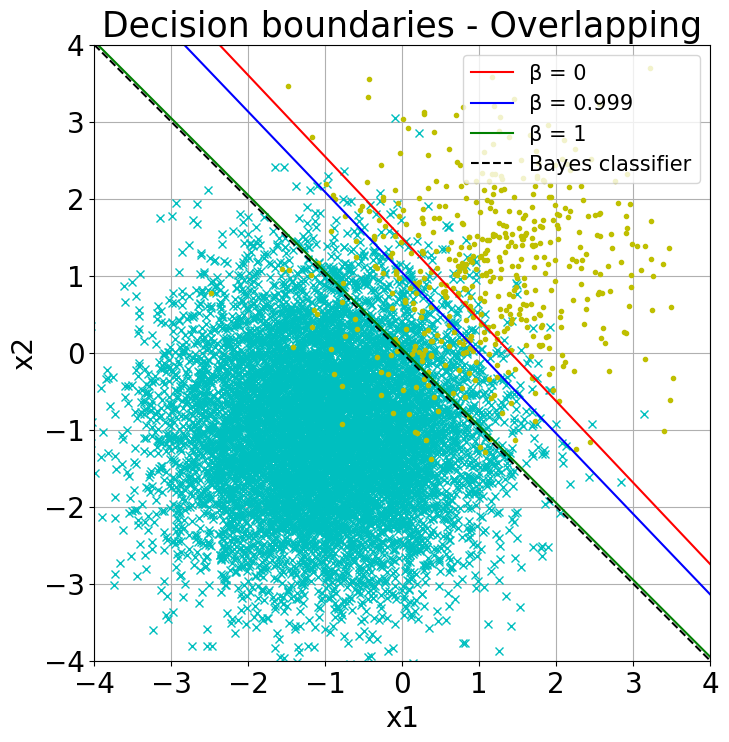

In [25]:
# Show the synthetic data
plt.plot(sampA[:,0], sampA[:,1], 'cx')
plt.plot(sampB[:,0], sampB[:,1], '.y')
# Plot the decision boundaries - can plot boundaries for different models
# Plotting logit-adjusted models (multiplicative and additive updates) can be done as follows:

# plot_db(getwb(model_bin, mult=class_prob), modelType='Multiplicative update', lins='g')
# plot_db(getwb(model_bin, add=-np.log(class_prob)), modelType='Additive update', lins='b')


plot_db(getwb(model_bin), modelType='\u03B2 = 0', lins='r')
plot_db(getwb(model_bin_cui), modelType=f'\u03B2 = {beta}', lins='b')
plot_db(getwb(model_bin_bal), modelType='\u03B2 = 1', lins='g')
plot_db([[0,0], [1,1], 0, 0], modelType='Bayes classifier', lins='k--')
# Add legend, title, axes labels, general formatting, saving the plot
plt.legend(loc='best', fontsize=15)
plt.title('Decision boundaries - Overlapping', fontsize=25)
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axis('scaled')
plt.axis([-4,4,-4,4])
figure = plt.gcf()
figure.set_size_inches(8,8)
plt.savefig('../data/imbalOverlapWeighted.png', dpi=1200)
plt.show()

# Logit adjusted decision boundaries

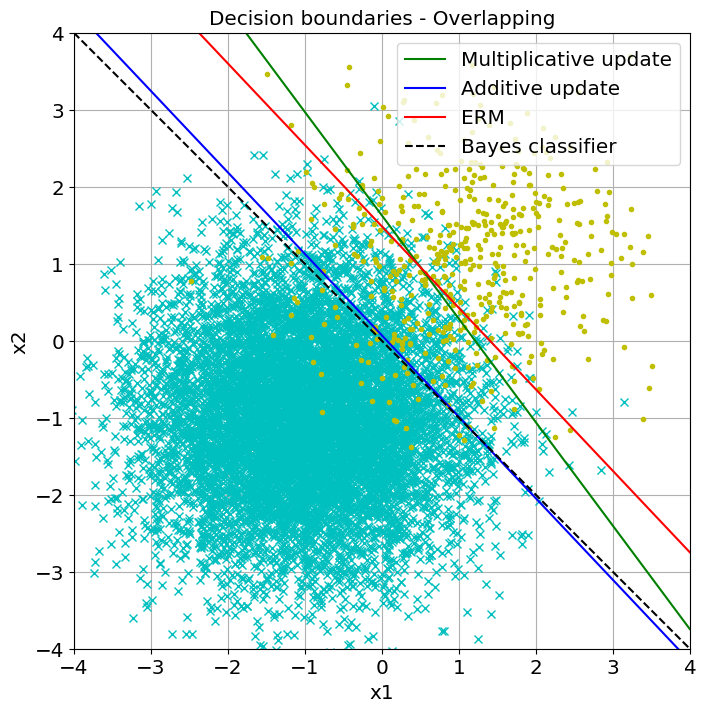

In [26]:
plt.plot(sampA[:,0], sampA[:,1], 'cx')
plt.plot(sampB[:,0], sampB[:,1], '.y')
# Plot decision boundaries for standard model with weights and biases adjusted according to update
plot_db(getwb(model_bin, mult=class_prob), modelType='Multiplicative update', lins='g')
plot_db(getwb(model_bin, add=-np.log(class_prob)), modelType='Additive update', lins='b')
plot_db(getwb(model_bin), modelType='ERM', lins='r')
plot_db([[0,0], [1,1], 0, 0], modelType='Bayes classifier', lins='k--')
plt.legend(loc='best')
plt.title('Decision boundaries - Overlapping')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()
plt.axis('scaled')
plt.axis([-4,4,-4,4])
figure = plt.gcf()
figure.set_size_inches(8,8)
plt.savefig('../data/imbalOverlapUpdate.png', dpi=1200)
plt.show()

# Margin adjusted loss decision boundaries

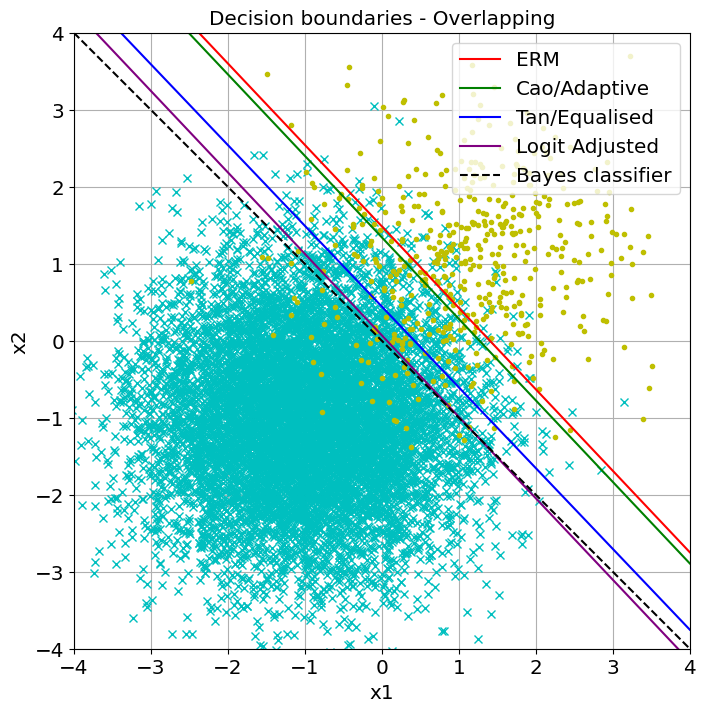

In [27]:
plt.plot(sampA[:,0], sampA[:,1], 'cx')
plt.plot(sampB[:,0], sampB[:,1], '.y')
plot_db(getwb(model_bin), modelType='ERM', lins='r')
plot_db(getwb(model_bin_cao), modelType='Cao/Adaptive', lins='g')
plot_db(getwb(model_bin_eq), modelType='Tan/Equalised', lins='b')
plot_db(getwb(model_bin_la), modelType='Logit Adjusted', lins='purple')
plot_db([[0,0], [1,1], 0, 0], modelType='Bayes classifier', lins='k--')
plt.legend(loc='best')
plt.title('Decision boundaries - Overlapping')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()
plt.axis('scaled')
plt.axis([-4,4,-4,4])
figure = plt.gcf()
figure.set_size_inches(8,8)
plt.savefig('../data/imbalOverlapMargin.png', dpi=1200)
plt.show()